# Compute ADU counts over time

Use inferred buildings for 2016, 2018 and 2020 to compute small building growth.

## 0. Set up

In [1]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage

In [2]:
import json
import geopandas as gpd
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pyproj
import rasterio
import rasterio.features
import rasterio.plot
import shapely
from shapely.geometry import box, Polygon
from tqdm import tqdm

tqdm.pandas()

In [3]:
def visualize_tile_full_year(fn, year):
    tile_bounds = get_bounds(tile_bounds_dict_all[year], fn)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    infer_tile = gpd.clip(building_footprints_infer[year], tile_bounds)
    zone_tile = gpd.clip(zoning, tile_bounds)

    raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(fn)))

    plt.clf()
    fig, ax = plt.subplots(figsize=(4, 4))
    rasterio.plot.show(raster, ax=ax,)
    zone_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='black', alpha=0.5)
    osm_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue')
    infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.5)
    plt.show()

## 1. Load data / Paths

In [4]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
TIF_FP = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/raw_tif', 
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/raw_tif',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
}

INFERENCES_DIR = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/infer',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/infer',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
}
NAIP_TIF = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2016',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2018',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2020',
}

YEARS = ['2016', '2018', '2020']

In [5]:
# Load tile dict for each year
tile_bounds_dict_all = {}
for year in ['2016', '2018', '2020']:
    OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}'.format(year))
    with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
        tile_bounds_dict = json.load(f)
        tile_bounds_dict_all[year] = tile_bounds_dict

In [6]:
# Load SJ shapefiles, zoning data and OSM data
cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
building_footprints_osm = gpd.read_file(os.path.join(OAK_FP, 'outputs/cbg-inference-2020/osm_building_processed'))

/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


[INFO] Restricting zoning data to R-1, R-2 and R-M (ex. R-MH)


In [7]:
# Load inferred buildings for all years and limit to small buildings
building_footprints_infer = {}
for year in YEARS:
    building_footprints_infer[year] = gpd.read_file(os.path.join(OAK_FP, 'outputs/cbg-inference-{}/inference_building_processed'.format(year)))

small_bfi = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer.items():
    gdf['year'] = year
    small_bfi = pd.concat([small_bfi, gdf])
small_bfi = small_bfi.loc[small_bfi['small'] == 1]

In [8]:
# Get tiles for all years
tiles_gdf = {}
for year in YEARS:
    tiles = glob.glob(os.path.join(INFERENCES_DIR[year], '*.npy'))
    tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]
    tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

    tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
        lambda name: get_bounds(tile_bounds_dict_all[year], name) if name in list(tile_bounds_dict_all[year].keys()) else None
    )
    tiles_gdf[year] = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

100%|██████████| 3074/3074 [00:00<00:00, 16571.46it/s]


<Figure size 640x480 with 0 Axes>

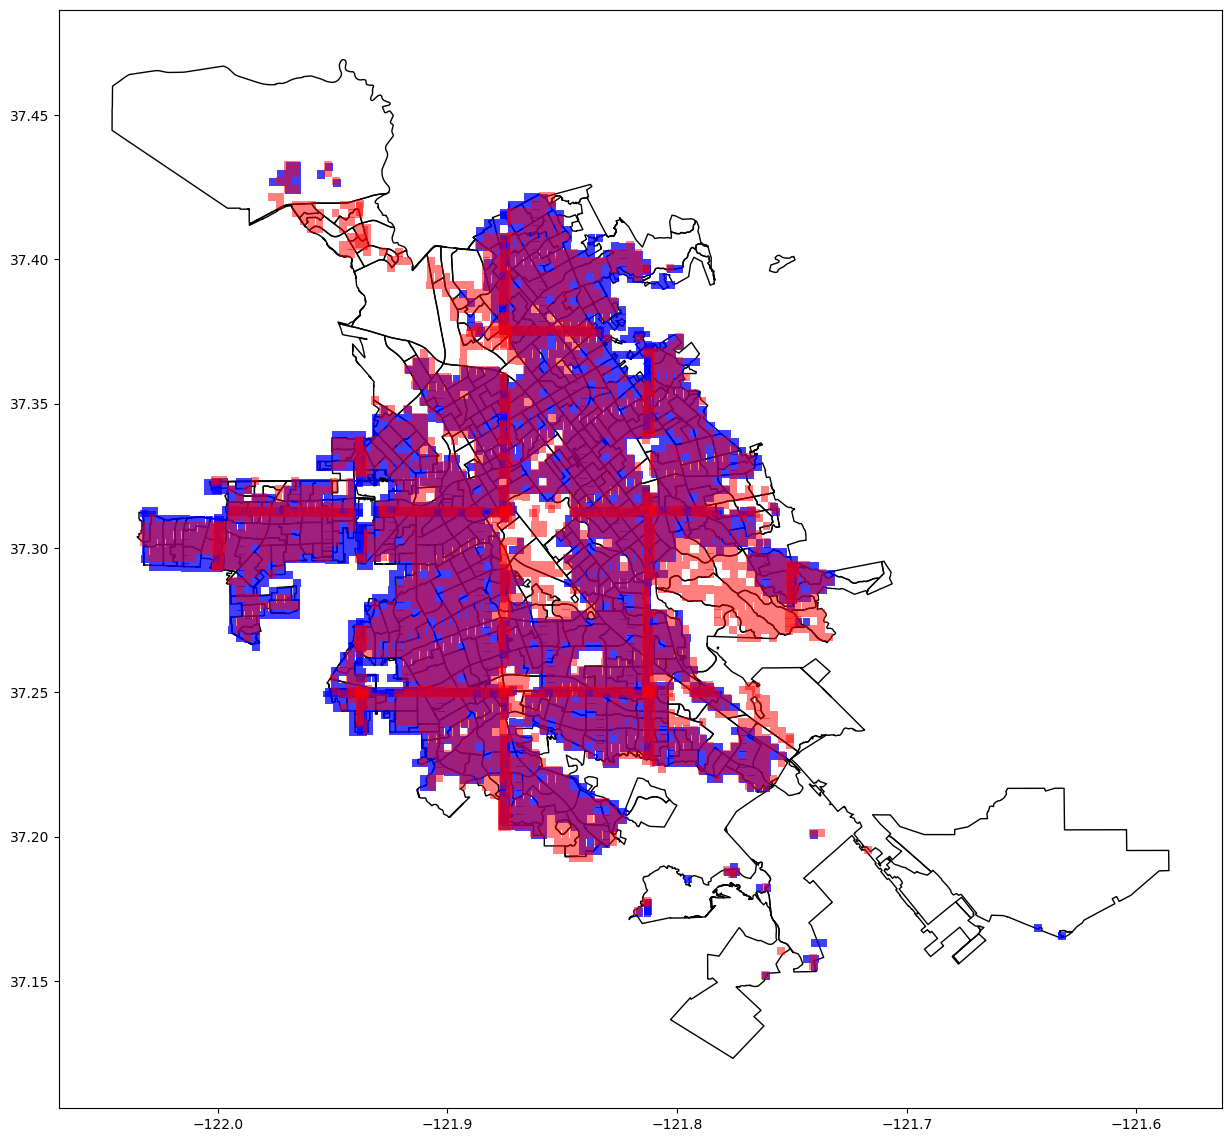

In [9]:
# Visualize all tiles
colors = {'2016': 'blue', '2018': 'blue', '2020': 'red'}

plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
for year in ['2016', '2018', '2020']:
    tiles_gdf[year].plot(ax=ax, facecolor=colors[year], alpha=0.5)
plt.show()

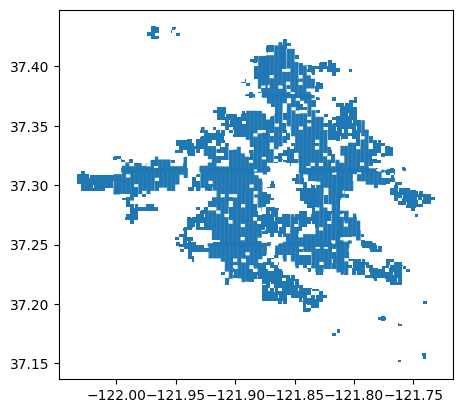

In [10]:
# Generate shp of tile intersection for all years
tile_intersection = (
    tiles_gdf['2016'].geometry.unary_union).intersection(
    tiles_gdf['2018'].geometry.unary_union).intersection(
    tiles_gdf['2020'].geometry.unary_union
)

# Check
gpd.GeoDataFrame(geometry=[tile_intersection]).plot()
plt.show()

In [10]:
# Find neighborhoods missing OSM annotations but having 2020 inferences

# * Toy example
xmin, ymin, xmax, ymax = [-121.884377, 37.317822, -121.876989, 37.314322]
b_20 = building_footprints_infer['2020'].cx[xmin:xmax, ymin:ymax]
b_osm = building_footprints_osm.cx[xmin:xmax, ymin:ymax]
zo = zoning.cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots()
zo.plot(ax=ax, edgecolor='black', facecolor='white')
b_osm.plot(ax=ax)
b_20.plot(ax=ax, color='red', alpha=0.5)
ax.axis('off')
plt.show()

# Import warnings just for this exercise given use of iloc
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)



In [29]:
zoning.head()

,OBJECTID,FACILITYID,ZONING,ZONINGABBREV,REZONINGFILE,PDUSE,PDDENSITY,DEVELOPEDASPD,APPROVALDATE,COLORCODE,LASTUPDATE,NOTES,SHAPE_Length,SHAPE_Area,geometry
4,5,5,R-1-5,R-1-5,C20-007,None,0,None,NaT,1,2022-04-22 20:37:06+00:00,None,2236.203702,57182.515879,"POLYGON ((-121.83224 37.19906, -121.83223 37.1..."
5,6,6,R-1-5,R-1-5,C20-007,None,0,None,NaT,1,2022-04-22 20:37:06+00:00,None,1465.209400,121965.879613,"POLYGON ((-121.83271 37.20329, -121.83298 37.2..."
14,16,13084,R-2,R-2,16017,None,0,None,NaT,2,2022-04-22 20:37:11+00:00,None,963.314208,43487.827340,"POLYGON ((-121.90327 37.23206, -121.90328 37.2..."
50,52,52,R-1-8,R-1-8,C21-045,None,0,None,2022-04-12 00:00:00+00:00,1,2022-05-06 00:01:55+00:00,None,340.294294,3980.577608,"POLYGON ((-121.97647 37.27770, -121.97659 37.2..."
78,80,80,R-1-8,R-1-8,C18-011,None,0,None,2018-10-23 00:00:00+00:00,17,2022-04-22 21:55:28+00:00,None,533.955178,13107.699466,"POLYGON ((-121.80104 37.31234, -121.80106 37.3..."


In [11]:
if not os.path.exists('missing_OSM_footprints.csv'):
    zoning_indices = pd.DataFrame()
    start_index = 0
else:
    zoning_indices = pd.read_csv('missing_OSM_footprints.csv')
    start_index = len(zoning_indices)

for i in tqdm(range(start_index, len(zoning))):
    zo = zoning.iloc[[i]]
    row = {'index': [i], 'OSM Missing': [None]}
    
    # Clip 2020 buildings and OSM
    b_20 = gpd.clip(building_footprints_infer['2020'], zo)
    
    if len(b_20) == 0:
        zoning_indices = pd.concat([zoning_indices, pd.DataFrame.from_dict(row)])
        continue
    
    b_osm = gpd.clip(building_footprints_osm, zo)
    
    # Sjoins
    zo_f = zo.sjoin(gpd.GeoDataFrame(geometry=[b_20.geometry.unary_union], crs='EPSG:4326'), 
                how='left', predicate='intersects')
    zo_f.rename(columns={'index_right': 'b20_index'}, inplace=True)
    
    zo_f = zo_f.sjoin(gpd.GeoDataFrame(geometry=[b_osm.geometry.unary_union], crs='EPSG:4326'), 
                  how='left', predicate='intersects')
    zo_f.rename(columns={'index_right': 'bosm_index'}, inplace=True)
    
    zo_f = zo_f.loc[(zo_f['bosm_index'].isna()) & (~zo_f['b20_index'].isna())]
    
    row['OSM Missing'] = True if len(zo_f) > 0 else False
    zoning_indices = pd.concat([zoning_indices, pd.DataFrame.from_dict(row)])
    
    if i % 50 == 0:
        zoning_indices.to_csv('missing_OSM_footprints.csv', index=False)
        
# Save 
missing_zones = zoning_indices.loc[zoning_indices['OSM Missing'] == True]['index'].unique()
zoning_missing = zoning.iloc[missing_zones]

zoning_missing[['ZONING', 'geometry']].to_file(
    '/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2020/Missing-OSM-Zones/OSM_missing')


0it [00:00, ?it/s]


## 2. Tile checks

Check 2016, 2018, 2020 tiles

Year: 2016


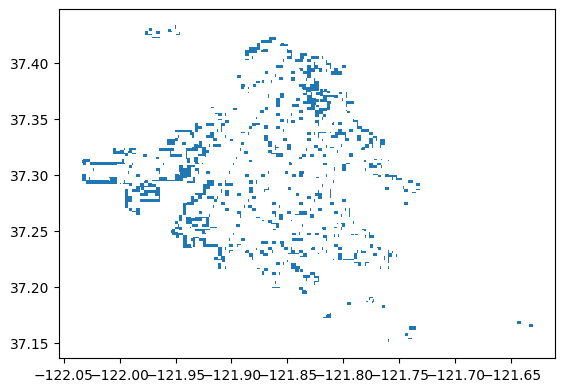

Inferred small building area in additional tiles: 
443636.0
Number of inferred small buildings in additional tiles: 
8813
Percentage of inferred small building area in additional tiles vs all tiles
15.47
Percentage of inferred small buildings in additional tiles vs all tiles
14.91
OSM Small build area in additional tiles: 
283734.95
OSM Number of small buildings in additional tiles: 
5408


Year: 2018


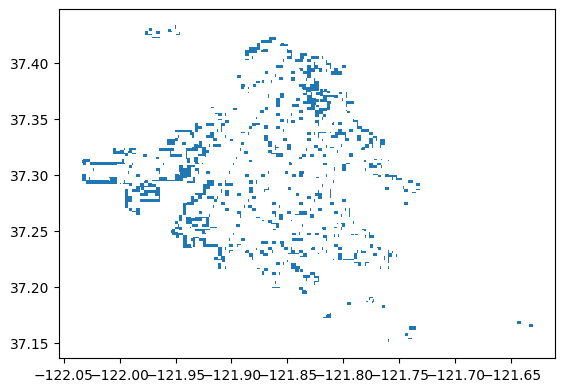

Inferred small building area in additional tiles: 
523282.0
Number of inferred small buildings in additional tiles: 
10290
Percentage of inferred small building area in additional tiles vs all tiles
15.86
Percentage of inferred small buildings in additional tiles vs all tiles
15.26
OSM Small build area in additional tiles: 
283734.95
OSM Number of small buildings in additional tiles: 
5408




In [11]:
# Check num buildings for tiles in 2016,18 not covered by 2020 tiles
for year in ['2016', '2018']:
    print('Year: {}'.format(year))
    tiles_year_ex20 = (tiles_gdf[year].geometry.unary_union).difference(tiles_gdf['2020'].geometry.unary_union)

    gpd.GeoDataFrame(geometry=[tiles_year_ex20]).plot()
    plt.show()
    
    test = gpd.clip(building_footprints_infer[year], tiles_year_ex20)

    print('Inferred small building area in additional tiles: ')
    print(round(test.loc[test['small'] == 1]['area'].sum(), 0))

    print('Number of inferred small buildings in additional tiles: ')
    print(test.loc[test['small'] == 1]['area'].count())

    print('Percentage of inferred small building area in additional tiles vs all tiles')
    print(round(test.loc[test['small'] == 1]['area'].sum() / (building_footprints_infer[year].loc[building_footprints_infer[year]['small'] == 1]['area'].sum()) * 100, 2))

    print('Percentage of inferred small buildings in additional tiles vs all tiles')
    print(round(test.loc[test['small'] == 1]['area'].count() / (building_footprints_infer[year].loc[building_footprints_infer[year]['small'] == 1]['area'].count()) * 100, 2))
    
    # Check OSM builds in this space
    osm_ext = gpd.clip(building_footprints_osm, tiles_year_ex20)
    
    print('OSM Small build area in additional tiles: ')
    print(round(osm_ext.loc[osm_ext['small'] == 1]['area'].sum(), 2))

    print('OSM Number of small buildings in additional tiles: ')
    print(osm_ext.loc[osm_ext['small'] == 1]['area'].count())
    
    print('\n')

Use raw tifs for 2020

In [12]:
# Get tile bounds dict
tile_bounds_dict_all['2020-raw'] = {}
for tif in tqdm(glob.glob(os.path.join(TIF_FP['2020'], '*.tif'))):
    file_name = tif.split(os.path.sep)[-1].replace('.tif', '')
    with rasterio.open(tif) as inds:
        bounds = inds.bounds
        geom = box(*bounds)

    # prepare to convert TIF bounds to standard 4326
    wgs84 = pyproj.CRS('EPSG:26910') # LA is 11, SJ is 10
    utm = pyproj.CRS('EPSG:4326')
    project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

    # Convert
    utm_geom = shapely.ops.transform(project, geom)
    tile_bounds_dict_all['2020-raw'][file_name] = list(utm_geom.exterior.coords)

100%|██████████| 4736/4736 [04:40<00:00, 16.88it/s]


In [13]:
# Get gpd and add to tiles_gdf dict
tiles = list(tile_bounds_dict_all['2020-raw'].keys())
tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
    lambda name: get_bounds(tile_bounds_dict_all['2020-raw'], name))
tiles_gdf['2020-raw'] = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

100%|██████████| 4736/4736 [00:00<00:00, 63816.70it/s]


<Figure size 640x480 with 0 Axes>

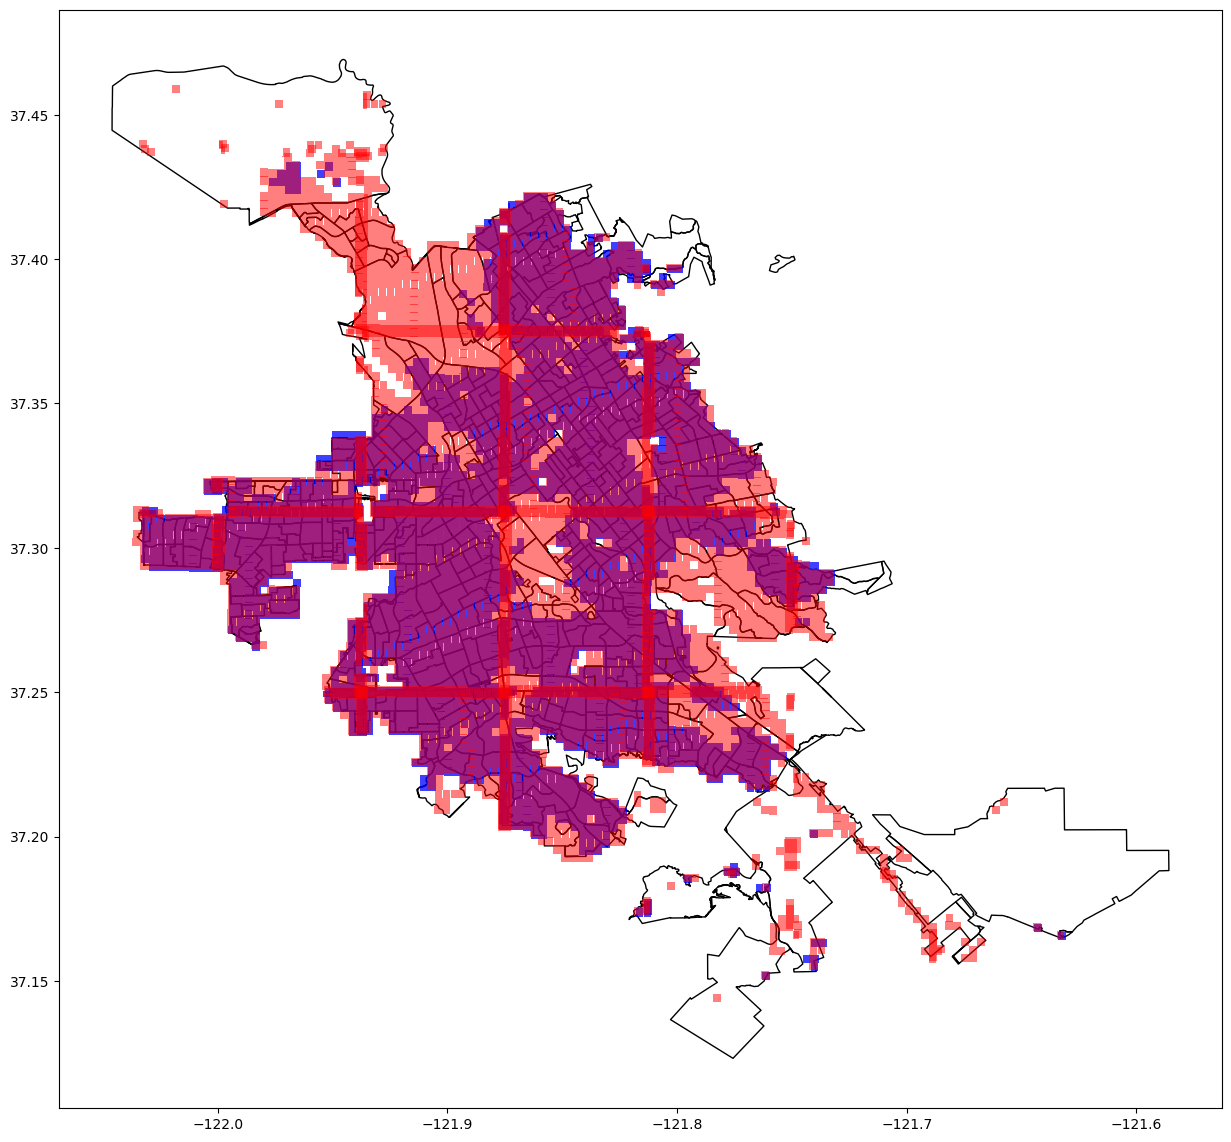

In [14]:
# Visualize all tiles
colors = {'2016': 'blue', '2018': 'blue', '2020': 'red'}

plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
for year in ['2016', '2018']:
    tiles_gdf[year].plot(ax=ax, facecolor=colors[year], alpha=0.5)
tiles_gdf['2020-raw'].plot(ax=ax, facecolor='red', alpha=0.5)
plt.show()

In [15]:
for key in tile_bounds_dict_all.keys():
    print('Year: {}; Number of tiles: {}'.format(key, len(tile_bounds_dict_all[key].keys())))

Year: 2016; Number of tiles: 3192
Year: 2018; Number of tiles: 3192
Year: 2020; Number of tiles: 3074
Year: 2020-raw; Number of tiles: 4736


Check tiles against original NAIP tiles

In [16]:
with open(os.path.join(NAIP_TIF['2020'], 'bounds.p'), 'rb') as f:
    p = pickle.load(f)

In [17]:
naip_gpd = gpd.GeoDataFrame(geometry=list(p.values()), crs='EPSG:4326')

<Figure size 640x480 with 0 Axes>

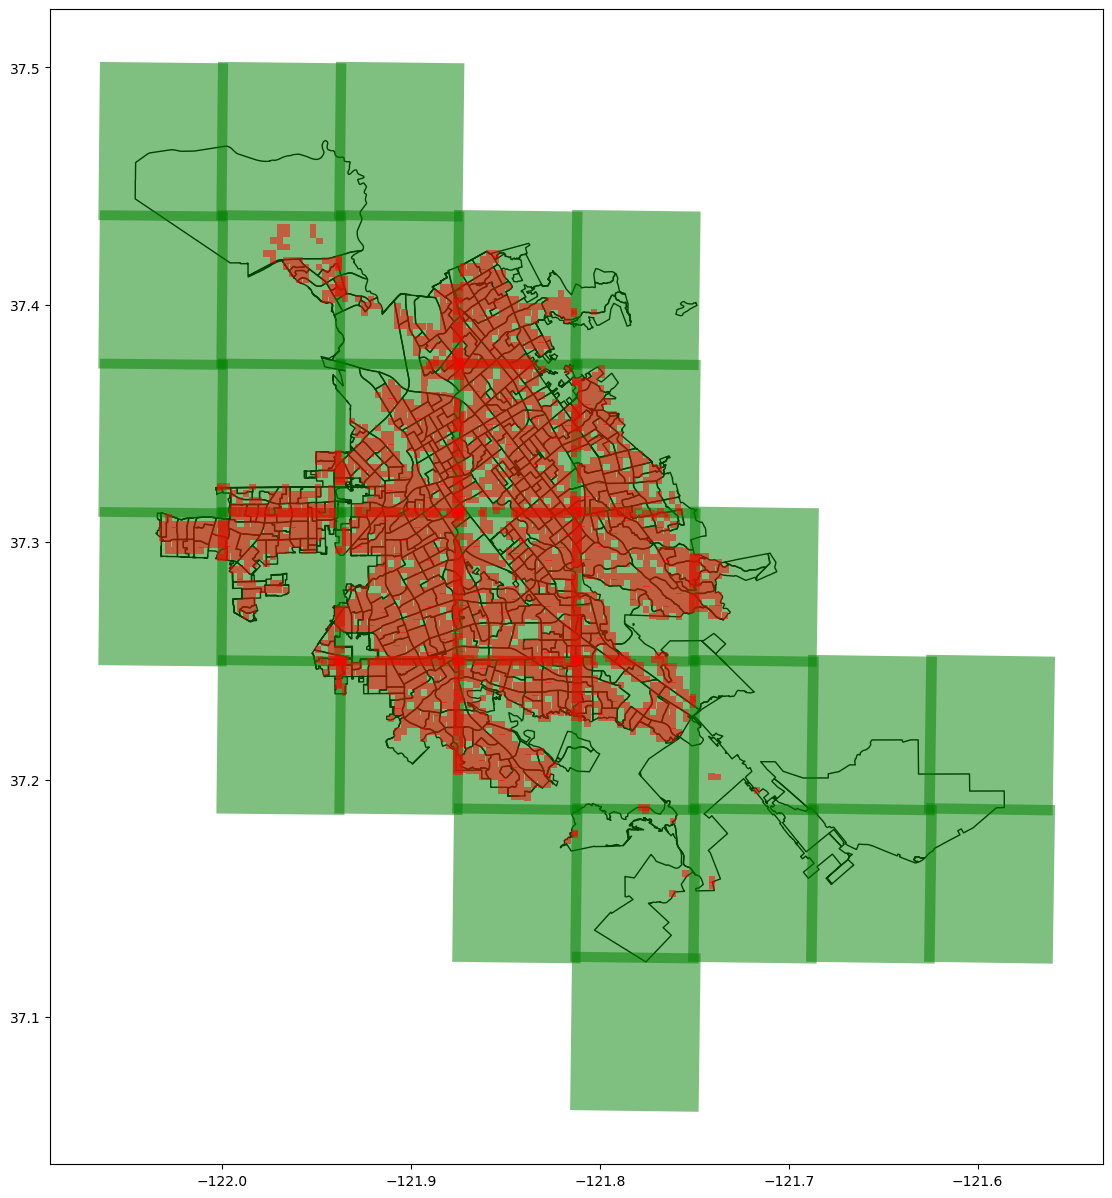

In [18]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
tiles_gdf['2020'].plot(ax=ax, facecolor='red', zorder=2, alpha=0.5)
naip_gpd.plot(ax=ax, facecolor='green', zorder=1, alpha=0.5)
plt.show()

## 3. Raw inferences

### 3.1 Over all tiles

In [19]:
# Number of tiles for each year
for year in YEARS:
    print('Year: {}; Num tiles: {}'.format(year, len(list(tile_bounds_dict_all[year].keys()))))

Year: 2016; Num tiles: 3192
Year: 2018; Num tiles: 3192
Year: 2020; Num tiles: 3074


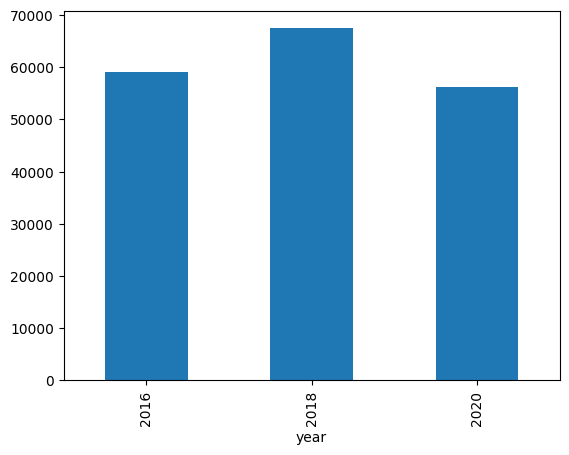

In [20]:
# Trends in raw small building counts
n_small_ts = small_bfi.groupby('year')['GEOID'].count()
n_small_ts.plot.bar()
plt.show()

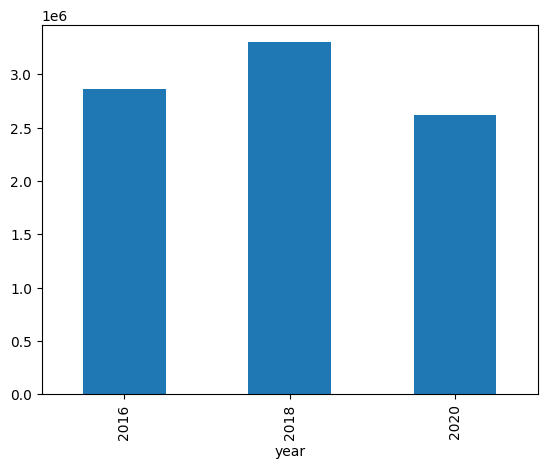

In [21]:
# Trends in raw small building area
a_small_ts = small_bfi.groupby('year')['area'].sum()
a_small_ts.plot.bar()
plt.show()

### 3.2 Over intersecting tiles for all 3 years

In [11]:
# Limit inferences to areas with tile overlap across all years
building_footprints_infer_clipped = {}
for year, gdf in building_footprints_infer.items():
    print(year)
    temp_file = os.path.join(OAK_FP, 'outputs', 'cbg-inference-dynamic', 'temp', 'bfi_small_clipped_{}'.format(year))
    if not os.path.exists(temp_file):
        temp = gpd.clip(gdf.loc[gdf['small']==1], tile_intersection)
        print(len(temp))
        temp = temp.geometry.explode(index_parts=True)
        temp = gpd.GeoDataFrame(geometry=temp)
        print(len(temp))
        temp = temp[temp.geom_type.isin(['Polygon', 'MultiPolygon'])]
        print(len(temp))
        temp.to_file(temp_file)
    building_footprints_infer_clipped[year] = gpd.read_file(temp_file)

2016
2018
2020


In [23]:
# Check
#building_footprints_infer_clipped['2016'].plot()
#plt.show()

In [12]:
small_bfi_clipped = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer_clipped.items():
    gdf['year'] = year
    small_bfi_clipped = pd.concat([small_bfi_clipped, gdf])

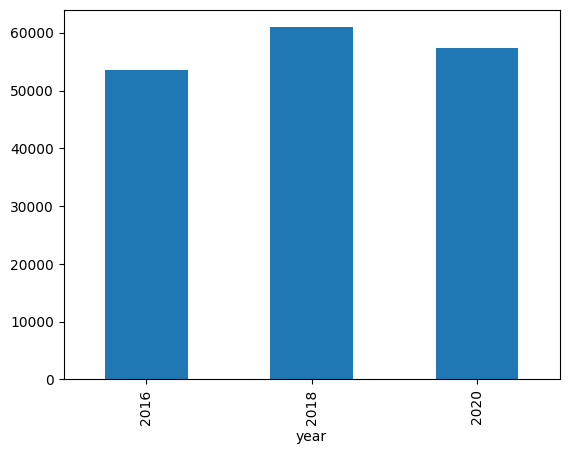

In [25]:
# Trends in raw small building counts
n_small_ts_clipped = small_bfi_clipped.groupby('year')['level_0'].count()
n_small_ts_clipped.plot.bar()
plt.show()

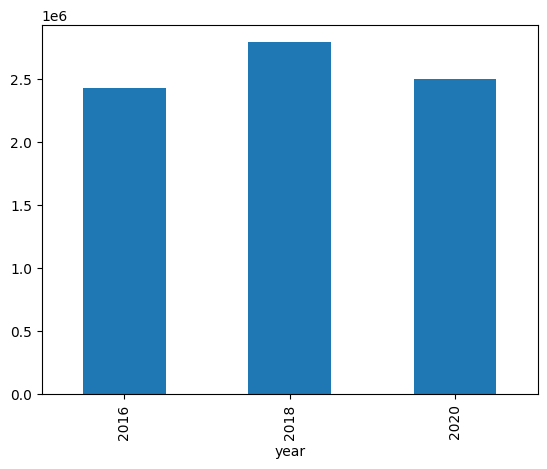

In [26]:
# Trends in raw small building area
small_bfi_clipped = small_bfi_clipped.to_crs('EPSG:26910')
small_bfi_clipped['area'] = small_bfi_clipped.area
small_bfi_clipped = small_bfi_clipped.to_crs('EPSG:4326')
a_small_ts_clipped = small_bfi_clipped.groupby('year')['area'].sum()
a_small_ts_clipped.plot.bar()
plt.show()

In [31]:
# Visualize tiles
#visualize_tile_full_year('m_3712149_ne_10_060_20200525_358', '2020')
#visualize_tile_full_year('m_3712149_ne_10_h_20160529_216', '2016')
#visualize_tile_full_year('m_3712141_ne_10_060_20180725_156', '2018')

Understand drop in 2020 numbers

In [13]:
# Aggregate at the CBG level to understand if this is evenly spatially distributed
small_bfi_clipped = assign_cbgs(small_bfi_clipped, cbg_sj)
small_bfi_clipped_agg = small_bfi_clipped.groupby(['GEOID', 'year'])['level_0'].count().reset_index()

In [14]:
small_bfi_clipped_agg = small_bfi_clipped_agg.merge(
    cbg_sj[['GEOID', 'geometry']], on='GEOID', how='left', validate='many_to_one')

In [15]:
small_bfi_clipped_agg = gpd.GeoDataFrame(small_bfi_clipped_agg)

In [16]:
small_bfi_clipped_agg.head()

,GEOID,year,level_0,geometry
0,060855001001,2016,143,"POLYGON ((-121.90449 37.36091, -121.90437 37.3..."
1,060855001001,2018,143,"POLYGON ((-121.90449 37.36091, -121.90437 37.3..."
2,060855001001,2020,140,"POLYGON ((-121.90449 37.36091, -121.90437 37.3..."
3,060855001002,2016,194,"POLYGON ((-121.89036 37.36277, -121.88871 37.3..."
4,060855001002,2018,222,"POLYGON ((-121.89036 37.36277, -121.88871 37.3..."


<Figure size 640x480 with 0 Axes>

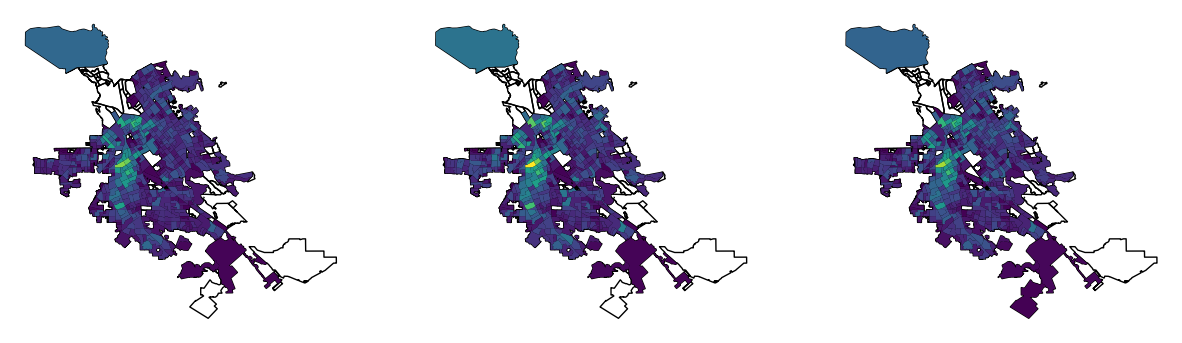

In [36]:
vmax=small_bfi_clipped_agg['level_0'].max()
vmin=small_bfi_clipped_agg['level_0'].min()

plt.clf()
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for ax, year in zip([ax1, ax2, ax3], ['2016', '2018', '2020']):
    cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
    ax = small_bfi_clipped_agg.loc[small_bfi_clipped_agg['year'] == year].plot(
        ax=ax, column='level_0', vmin=vmin, vmax=vmax, legend=False)
    ax.axis('off')
plt.show()

In [17]:
# Plot residuals for 2020
small_bfi_clipped_agg_dcast = (small_bfi_clipped_agg.pivot_table(
    index=['GEOID'], columns='year', values='level_0'
    ).reset_index())
# Add back geometry data
small_bfi_clipped_agg_dcast = small_bfi_clipped_agg_dcast.merge(
    cbg_sj[['GEOID', 'geometry']], on='GEOID', how='left', validate='one_to_one')

In [18]:
small_bfi_clipped_agg_dcast['16-20'] = small_bfi_clipped_agg_dcast['2016'] - small_bfi_clipped_agg_dcast['2020']
small_bfi_clipped_agg_dcast['18-20'] = small_bfi_clipped_agg_dcast['2018'] - small_bfi_clipped_agg_dcast['2020']

In [19]:
small_bfi_clipped_agg_dcast = gpd.GeoDataFrame(small_bfi_clipped_agg_dcast)

In [20]:
small_bfi_clipped_agg_dcast.head()

,GEOID,2016,2018,2020,geometry,16-20,18-20
0,060855001001,143.0,143.0,140.0,"POLYGON ((-121.90449 37.36091, -121.90437 37.3...",3.0,3.0
1,060855001002,194.0,222.0,203.0,"POLYGON ((-121.89036 37.36277, -121.88871 37.3...",-9.0,19.0
2,060855001003,265.0,263.0,253.0,"POLYGON ((-121.88916 37.35724, -121.88859 37.3...",12.0,10.0
3,060855001004,310.0,310.0,315.0,"POLYGON ((-121.89936 37.35529, -121.89915 37.3...",-5.0,-5.0
4,060855002001,367.0,450.0,398.0,"POLYGON ((-121.91083 37.35458, -121.91082 37.3...",-31.0,52.0


<Figure size 640x480 with 0 Axes>

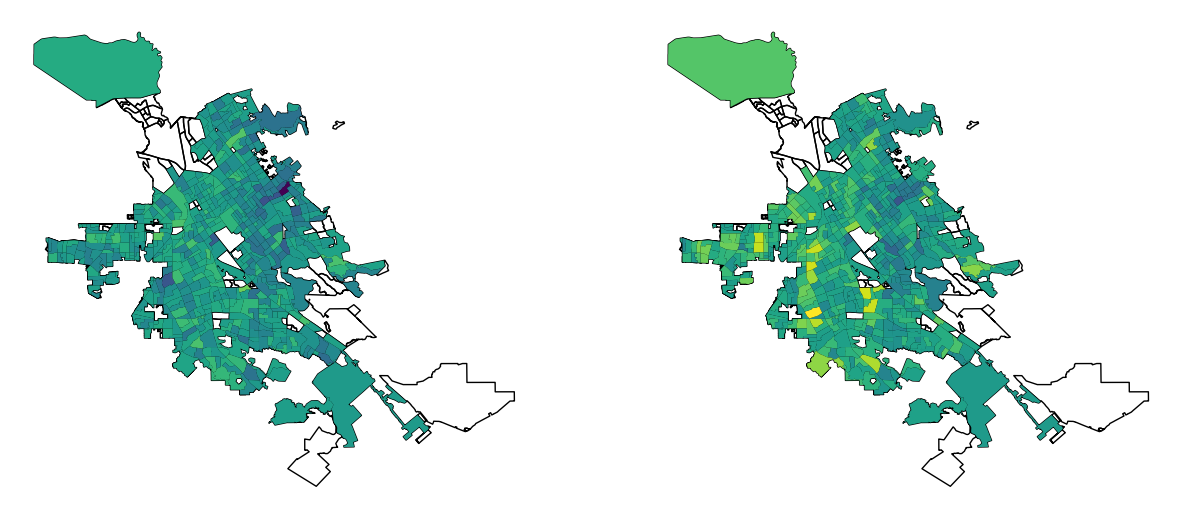

In [41]:
vmax=small_bfi_clipped_agg_dcast[['16-20', '18-20']].max().max()
vmin=small_bfi_clipped_agg_dcast[['16-20', '18-20']].min().min()

plt.clf()
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, year in zip([ax1, ax2], ['16', '18']):
    cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
    ax = small_bfi_clipped_agg_dcast.plot(
        ax=ax, column='{}-20'.format(year), vmin=vmin, vmax=vmax, legend=False)
    ax.axis('off')
plt.show()

In [21]:
# If evenly spaced, visualize random tiles in highest-difference 2018 CBGs
small_bfi_clipped_agg_dcast.sort_values('18-20', ascending=False).head()

,GEOID,2016,2018,2020,geometry,16-20,18-20
132,060855029082,345.0,422.0,320.0,"POLYGON ((-121.91509 37.25624, -121.91501 37.2...",25.0,102.0
492,060855120055,138.0,242.0,156.0,"POLYGON ((-121.86083 37.27432, -121.86030 37.2...",-18.0,86.0
104,060855026013,154.0,227.0,142.0,"POLYGON ((-121.91306 37.29442, -121.91283 37.2...",12.0,85.0
509,060855120251,172.0,239.0,156.0,"POLYGON ((-121.85888 37.25722, -121.85880 37.2...",16.0,83.0
86,060855023012,497.0,606.0,524.0,"POLYGON ((-121.91361 37.30167, -121.91361 37.3...",-27.0,82.0


In [22]:
small_bfi_clipped_agg_dcast.loc[small_bfi_clipped_agg_dcast['GEOID'] == '060855029022']

,GEOID,2016,2018,2020,geometry,16-20,18-20
121,060855029022,176.0,242.0,193.0,"POLYGON ((-121.92214 37.26760, -121.92164 37.2...",-17.0,49.0


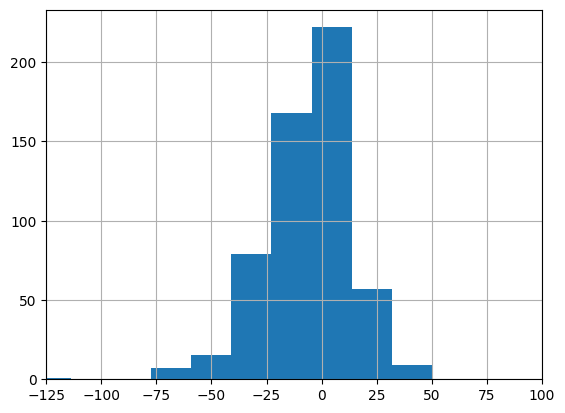

In [33]:
small_bfi_clipped_agg_dcast['16-20'].hist()
plt.xlim((-125, 100))
plt.show()

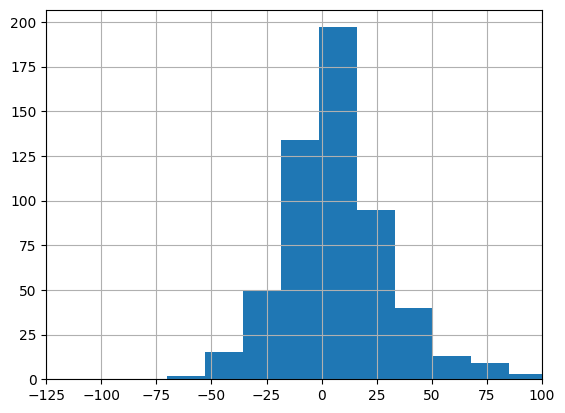

In [34]:
small_bfi_clipped_agg_dcast['18-20'].hist()
plt.xlim((-125, 100))
plt.show()

In [25]:
# Viualize tiles in GEOID: 060855029022
selected_geoid = '060855029022'

# 2016 tiles in this GEOID
geoid_2016_tiles = tiles_gdf['2016'].copy()
geoid_2016_tiles = gpd.clip(geoid_2016_tiles, cbg_sj.unary_union)
geoid_2016_tiles = assign_cbgs_by_coverage(geoid_2016_tiles, cbg_sj)
geoid_2016_tiles = geoid_2016_tiles.loc[geoid_2016_tiles['GEOID'] == selected_geoid]

# 2020 tiles in this GEOID
geoid_2020_tiles = tiles_gdf['2020'].copy()
geoid_2020_tiles = assign_cbgs_by_coverage(geoid_2020_tiles, cbg_sj)
geoid_2020_tiles = geoid_2020_tiles.loc[geoid_2020_tiles['GEOID'] == selected_geoid]

# 2018 tiles in this GEOID 
geoid_2018_tiles = tiles_gdf['2018'].copy()
geoid_2018_tiles = gpd.clip(geoid_2018_tiles, cbg_sj.unary_union)
geoid_2018_tiles = assign_cbgs_by_coverage(geoid_2018_tiles, cbg_sj)
geoid_2018_tiles = geoid_2018_tiles.loc[geoid_2018_tiles['GEOID'] == selected_geoid]

100%|██████████| 7608/7608 [00:09<00:00, 769.39it/s]


In [1]:
print('2016')
for file_name in geoid_2016_tiles['file'].unique():
    visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all['2016'], 
        building_footprints_infer=building_footprints_infer['2016'], 
        building_footprints_osm=building_footprints_osm,
        file_name=file_name, 
        img_fp=os.path.join(OAK_FP, 'san_jose_naip_512', '2016', 'superresx2'), 
        tif_fp=TIF_FP['2016'], final_output_fp=None, save=False, small=False)

2016


In [2]:
print('2018')
for file_name in geoid_2018_tiles['file'].unique():
    visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all['2018'], 
        building_footprints_infer=building_footprints_infer['2018'], 
        building_footprints_osm=building_footprints_osm,
        file_name=file_name, 
        img_fp=os.path.join(OAK_FP, 'san_jose_naip_512', '2018', 'superresx2'), 
        tif_fp=TIF_FP['2018'], final_output_fp=None, save=False, small=False)

2018


In [ ]:
print('2020')
for file_name in geoid_2020_tiles['file'].unique():
    visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all['2020'], 
        building_footprints_infer=building_footprints_infer['2020'], 
        building_footprints_osm=building_footprints_osm,
        file_name=file_name, 
        img_fp=os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2'), 
        tif_fp=TIF_FP['2020'], final_output_fp=None, save=False, small=False)

In [30]:
# Viualize tiles in GEOID: 060855029082
selected_geoid = '060855029082'

# 2016 tiles in this GEOID
geoid_2016_tiles = tiles_gdf['2016'].copy()
geoid_2016_tiles = gpd.clip(geoid_2016_tiles, cbg_sj.unary_union)
geoid_2016_tiles = assign_cbgs_by_coverage(geoid_2016_tiles, cbg_sj)
geoid_2016_tiles = geoid_2016_tiles.loc[geoid_2016_tiles['GEOID'] == selected_geoid]

# 2020 tiles in this GEOID
geoid_2020_tiles = tiles_gdf['2020'].copy()
geoid_2020_tiles = assign_cbgs_by_coverage(geoid_2020_tiles, cbg_sj)
geoid_2020_tiles = geoid_2020_tiles.loc[geoid_2020_tiles['GEOID'] == selected_geoid]

# 2018 tiles in this GEOID 
geoid_2018_tiles = tiles_gdf['2018'].copy()
geoid_2018_tiles = gpd.clip(geoid_2018_tiles, cbg_sj.unary_union)
geoid_2018_tiles = assign_cbgs_by_coverage(geoid_2018_tiles, cbg_sj)
geoid_2018_tiles = geoid_2018_tiles.loc[geoid_2018_tiles['GEOID'] == selected_geoid]

100%|██████████| 7608/7608 [00:10<00:00, 752.26it/s]


In [3]:
print('2018')
for file_name in geoid_2018_tiles['file'].unique():
    visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all['2018'], 
        building_footprints_infer=building_footprints_infer['2018'], 
        building_footprints_osm=building_footprints_osm,
        file_name=file_name, 
        img_fp=os.path.join(OAK_FP, 'san_jose_naip_512', '2018', 'superresx2'), 
        tif_fp=TIF_FP['2018'], final_output_fp=None, save=False, small=False)

2018


In [4]:
print('2020')
for file_name in geoid_2020_tiles['file'].unique():
    visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all['2020'], 
        building_footprints_infer=building_footprints_infer['2020'], 
        building_footprints_osm=building_footprints_osm,
        file_name=file_name, 
        img_fp=os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2'), 
        tif_fp=TIF_FP['2020'], final_output_fp=None, save=False, small=False)

2020
